# Super Store Project: Customer Segmentation and Insight

#1.Context

SuperStore is a global retail company with a large customer base. To celebrate Christmas and New Year, the Marketing department wants to launch to show appreciation to loyal customers who have supported the company over the years, as well as to engage potential customers who could become loyal clients.

#2.Problem

2.1 Problem understanding
- The marketing department proposed a plan using RFM model (Recency, Frequency, Monatery) in Python to segment customer, then launch marketing campaigns to give thank you letter to loyal customer, exploit potential customer to become loyal customer.
- Suggest to the Marketing and Sales team with the company's retail model, which of the three indicators R, F, M should be most interested in?
2.2 Problem breakdown
- Apply suggested RFM model  to lauch marketing campaig to give thank you letter to loyal customer & exploit potential customer to become loyal customer: define RFM model, identify customer segmentation for the campaign (loyal customer = champions, potential customer = customer who has high average of orders value, high first order value with large quantity ...?)
- How to find one of R, F, M should focus on: research citeria of company's industry to choose suitable indicators, check strengths and weakness of company based on RFM to make decision.


















#3.EDA

In [ ]:
# @title Import Packages
%%capture
!pip install squarify
!pip install ydata-profiling
from ydata_profiling import ProfileReport
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import squarify

## 3.1 Understand about data type & data value

In [ ]:
# @title Load dataset
%%capture
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/American Preparation/DAC K33/Python_Final Project RFM/Final_project_RFM/'
df = pd.read_excel(path+'ecommerce retail.xlsx', sheet_name = 'ecommerce retail')
df.head()


In [ ]:
# @title Get information about data type & data value
#get information about data type each column in table
print(df.info())
print('')
#get information about data value each column in table (min, max, count,...)
print(df.describe())
print('')
#df.head()
df=pd.read_excel(path+'ecommerce retail.xlsx',sheet_name = 'ecommerce retail')
df.head()

Comment:
- Data type:
CustomerID: float64 -> should convert to object
- Data Value:Min of Quantity < 0 -> detect reasons | Min of Price < 0 -> detect reasons.


In [ ]:
# @title Understand more about data type
profile = ProfileReport(df)
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 8/8 [00:03<00:00,  2.14it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
# @title Detect reasons about unsual data (Quanity < 0)
#Print some values have quantity < 0
print('Some values have quantity < 0')
print(df[df.Quantity <0].head())
print('')

#Check reasons about quantity <0 due to transaction cancellation or system cleanup
print('Check reasons about quantity <0 due to transaction cancellation')
df['check_cancel'] = df['InvoiceNo'].astype(str).apply(lambda x: True if x[0] == 'C' else False)
print(df[(df.Quantity <0) & (df.check_cancel == True)].head())
print('')
print('Check reasons about quantity <0 due to system cleanup')
print(df[(df.Quantity <0) & (df.check_cancel == False)].head())

Comment about quantity < 0:
- Quantity < 0 and unitprice > 0 -> check_cancel = True means cancelled transactions or returns which after the company recorded a sale, but customer return item => Delete rows.
- Quantity <0 and unitprice = 0, customerId = NaN -> check_cancel = False means system cleanup which is manual system adjustments => Delete rows.


In [ ]:
# @title Detect reasons about unsual data (Price < 0)
#Print some values have price < 0
print('Some values have price < 0')
print(df[df.UnitPrice <0].head())
print('')

Comment about price < 0:
- Letter A before InvoiceNo mean 'Adjust bad debt' which is a finacial adjustment (not a sale). This means the company expected to get paid for something but customer never paid -> invoice became bad debt, so they have to reverse that sale in the accounting system => Delete rows.
- Instead of deleting the old sales, they create a new invoice with quantity = 1, unitprice = negative value, customerId = NaN to balance the books and reduce revenue.

In [ ]:
# @title Handle unsual data type
#Correct data type
print(df.columns)
print('')

column_list = ['InvoiceNo','StockCode','Description','CustomerID','Country']
for c in column_list:
  df[c] = df[c].astype(str)
df.info()

In [ ]:
# @title Handle unsual data value
#drop data values have price < 0
df = df[df['UnitPrice'] > 0]

#drop data values have quantity < 0
df = df[df['Quantity'] > 0]
df = df.replace('nan',None)

df.shape

(530104, 9)

## 3.2 Handle missing and duplicated data

In [ ]:
# @title List out missing data
print('List out missing data')
missing_data = {'volume': df.isnull().sum(), 'percent':df.isnull().sum()/df.shape[0]}
missing_df = pd.DataFrame.from_dict(missing_data, orient='index')
missing_df.head()


List out missing data


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,check_cancel
volume,0.0,0.0,0.0,0.0,0.0,0.0,132220.000000,0.0,0.0
percent,0.0,0.0,0.0,0.0,0.0,0.0,0.249423,0.0,0.0


In [ ]:
# @title Detect reasons about missing data (CustomerID)
print(df[df.CustomerID.isnull()].head())

print('')

print(df[df.CustomerID.isnull()].tail())
df['Day'] = pd.to_datetime(df['InvoiceDate']).dt.date
df['Month'] = df['Day'].apply(lambda x: str(x)[:7]) #Fixed to get the correct month format

df_group_day = df[df.CustomerID.isnull()][['Month','InvoiceNo']].groupby(['Month']).count().reset_index().sort_values(by=['Month'], ascending = True)
df_group_day.head()

In [ ]:
# @title Handle missing data
#drop missing data
df = df[df['CustomerID'].notnull()]
df.head()

In [ ]:
# @title List out duplicated data
df_duplication = df.duplicated(subset=['InvoiceNo','StockCode','InvoiceDate','CustomerID'])
print(df[df_duplication].shape)
print('')
print(df.shape)

(10038, 11)

(397884, 11)


In [ ]:
# @title Detect reasons about duplicated data
print(df[df_duplication].head())

Possible reasons of duplicated data from:
- Customer added same item more than once in invoice.
- Manual entry error.


In [ ]:
# @title Handle duplicated data
df_drop_dup = df.drop_duplicates(subset=['InvoiceNo','StockCode','InvoiceDate','CustomerID'],keep = 'first')
df_drop_dup.shape

(387846, 11)

# 4.Data Processing

## 4.1 Identify RFM

In [ ]:
#Create Cost column
#Cost = Quantity * Price
df_drop_dup['Cost'] = df_drop_dup['Quantity'] * df_drop_dup['UnitPrice']
df_drop_dup.head()

<ipython-input-15-719f40529d73>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_drop_dup['Cost'] = df_drop_dup['Quantity'] * df_drop_dup['UnitPrice']


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,check_cancel,Day,Month,Cost
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,False,2010-12-01,2010-12,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,False,2010-12-01,2010-12,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,False,2010-12-01,2010-12,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,False,2010-12-01,2010-12,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,False,2010-12-01,2010-12,20.34


In [ ]:
#Identify last day
last_day = df_drop_dup['InvoiceDate'].max()
last_day

Timestamp('2011-12-09 12:50:00')

In [ ]:
# @title Create RFM_df
RFM_df = df_drop_dup.groupby('CustomerID').agg(
    Recency = ('Day',lambda x: (pd.to_datetime(last_day).date() - x.max()).days), # Convert last_day to datetime.date
    Frequency = ('CustomerID','count'),
    Monetary = ('Cost','sum'),
    Start_Day = ('Day','min')).reset_index()

RFM_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4338 entries, 0 to 4337
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CustomerID  4338 non-null   object 
 1   Recency     4338 non-null   int64  
 2   Frequency   4338 non-null   int64  
 3   Monetary    4338 non-null   float64
 4   Start_Day   4338 non-null   object 
dtypes: float64(1), int64(2), object(2)
memory usage: 169.6+ KB


In [ ]:
#Convert data type
RFM_df['Start_Day'] = pd.to_datetime(RFM_df['Start_Day'])
RFM_df['Start_Month']=pd.to_datetime(RFM_df['Start_Day']).apply(lambda x: str(x)[:7])

In [ ]:
# @title Create R, F, M (using qcut)
RFM_df['R'] = pd.qcut(RFM_df['Recency'],5,labels = range(1,6)).astype(str)
RFM_df['F'] = pd.qcut(RFM_df['Frequency'],5,labels = range(1,6)).astype(str)
RFM_df['M'] = pd.qcut(RFM_df['Monetary'],5,labels = range(1,6)).astype(str)
RFM_df['RFM'] = RFM_df.apply(lambda x: x.R + x.F + x.M, axis = 1)
RFM_df.head()

,CustomerID,Recency,Frequency,Monetary,Start_Day,Start_Month,R,F,M,RFM
0,12346.0,325,1,77183.60,2011-01-18,2011-01,5,1,5,515
1,12347.0,2,182,4310.00,2010-12-07,2010-12,1,5,5,155
2,12348.0,75,27,1595.64,2010-12-16,2010-12,4,2,4,424
3,12349.0,18,73,1757.55,2011-11-21,2011-11,2,4,4,244
4,12350.0,310,17,334.40,2011-02-02,2011-02,5,2,2,522


## 4.2 Identify Segmentation

In [ ]:
# @title Extract Segmention Sheet
#Read 'Segmention' Sheet
df_seg = pd.read_excel(path+ 'ecommerce retail.xlsx', sheet_name='Segmentation')
#Split value 'RFM Score' column
df_seg['RFM Score'] = df_seg['RFM Score'].str.split(',')
df_seg = df_seg.explode('RFM Score').reset_index(drop=True)
df_seg.head()


,Segment,RFM Score
0,Champions,555
1,Champions,554
2,Champions,544
3,Champions,545
4,Champions,454


In [ ]:
# @title Identify Segmentation from RFM Score (merge)
# Đoạn này vì mình nhấn Run merge nhiều lần nên bị lỗi, nên mình mới phải làm như vậy nhé Hằng!
# Bước 1: Lấy các cột cần thiết từ bảng phân khúc df_seg
df_seg_cleaned = df_seg[['RFM Score', 'Segment']].drop_duplicates()

# Bước 2: Merge RFM_df với phân khúc
RFM_df_final = RFM_df.merge(df_seg_cleaned, how='left', left_on='RFM', right_on='RFM Score')

# (Tuỳ chọn) Sắp xếp lại thứ tự cột cho đẹp
cols = ['CustomerID', 'Recency', 'Frequency', 'Monetary', 'Start_Day','Start_Month', 'R', 'F', 'M', 'RFM', 'Segment']
RFM_df_final = RFM_df_final[cols]
RFM_df_final.head()

,CustomerID,Recency,Frequency,Monetary,Start_Day,Start_Month,R,F,M,RFM,Segment
0,12346.0,325,1,77183.60,2011-01-18,2011-01,5,1,5,515,NaN
1,12347.0,2,182,4310.00,2010-12-07,2010-12,1,5,5,155,Cannot Lose Them
2,12348.0,75,27,1595.64,2010-12-16,2010-12,4,2,4,424,Promising
3,12349.0,18,73,1757.55,2011-11-21,2011-11,2,4,4,244,NaN
4,12350.0,310,17,334.40,2011-02-02,2011-02,5,2,2,522,NaN


Comment:
- Need to handle value 'NaN' in Segment

In [ ]:
#Removing leading and trailing whitespace in values of RFM Score column
df_seg_cleaned['RFM Score'] = df_seg_cleaned['RFM Score'].apply(lambda x: x.strip())
df_seg_cleaned.head()

,RFM Score,Segment
0,555,Champions
1,554,Champions
2,544,Champions
3,545,Champions
4,454,Champions


In [ ]:
#Merge again
RFM_df_final = RFM_df.merge(df_seg_cleaned, how='left', left_on='RFM', right_on='RFM Score')
cols = ['CustomerID', 'Recency', 'Frequency', 'Monetary', 'Start_Day','Start_Month', 'R', 'F', 'M', 'RFM', 'Segment']
RFM_df_final = RFM_df_final[cols]
RFM_df_final.head()

,CustomerID,Recency,Frequency,Monetary,Start_Day,Start_Month,R,F,M,RFM,Segment
0,12346.0,325,1,77183.60,2011-01-18,2011-01,5,1,5,515,Promising
1,12347.0,2,182,4310.00,2010-12-07,2010-12,1,5,5,155,Cannot Lose Them
2,12348.0,75,27,1595.64,2010-12-16,2010-12,4,2,4,424,Promising
3,12349.0,18,73,1757.55,2011-11-21,2011-11,2,4,4,244,At Risk
4,12350.0,310,17,334.40,2011-02-02,2011-02,5,2,2,522,Promising


## 4.3 Find Customer Characteristics

In [ ]:
# @title Update Loyal Status
RFM_df_final['Loyal Status'] = RFM_df_final['Segment'].apply(lambda x: 'Loyal' if x in ('Loyal','Potential Loyalist')else 'None Loyal')
RFM_df_final.head()


,CustomerID,Recency,Frequency,Monetary,Start_Day,Start_Month,R,F,M,RFM,Segment,Loyal Status
0,12346.0,325,1,77183.60,2011-01-18,2011-01,5,1,5,515,Promising,None Loyal
1,12347.0,2,182,4310.00,2010-12-07,2010-12,1,5,5,155,Cannot Lose Them,None Loyal
2,12348.0,75,27,1595.64,2010-12-16,2010-12,4,2,4,424,Promising,None Loyal
3,12349.0,18,73,1757.55,2011-11-21,2011-11,2,4,4,244,At Risk,None Loyal
4,12350.0,310,17,334.40,2011-02-02,2011-02,5,2,2,522,Promising,None Loyal


In [ ]:
# @title Find average of order cost, average of order quantity
RFM_df_average = df_drop_dup.groupby('CustomerID').agg(
    Avg_Cost = ('Cost','mean'),
    Avg_Quantity = ('Quantity','mean')
).reset_index()
RFM_df_average.head()

,CustomerID,Avg_Cost,Avg_Quantity
0,12346.0,77183.600000,74215.000000
1,12347.0,23.681319,13.505495
2,12348.0,59.097778,68.925926
3,12349.0,24.076027,8.643836
4,12350.0,19.670588,11.588235


In [ ]:
#Create Row Number column
df_drop_dup['Row Number'] = df_drop_dup.groupby('CustomerID').cumcount() + 1
df_drop_dup.head()

<ipython-input-26-a28e0cea7a7f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_drop_dup['Row Number'] = df_drop_dup.groupby('CustomerID').cumcount() + 1


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,check_cancel,Day,Month,Cost,Row Number
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,False,2010-12-01,2010-12,15.30,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,False,2010-12-01,2010-12,20.34,2
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,False,2010-12-01,2010-12,22.00,3
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,False,2010-12-01,2010-12,20.34,4
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,False,2010-12-01,2010-12,20.34,5


In [ ]:
# @title Find first order cost, first order quantity
RFM_df_first = df_drop_dup[df_drop_dup['Row Number'] == 1][['CustomerID','Cost','Quantity']]
RFM_df_first.columns = ['CustomerID','First_Cost','First_Quantity']
RFM_df_first.head()

,CustomerID,First_Cost,First_Quantity
0,17850.0,15.30,6
9,13047.0,54.08,32
26,12583.0,90.00,24
46,13748.0,204.00,80
65,15100.0,350.40,32


In [ ]:
# @title Merge RFM_df_average and RFM_df_first in RFM_df_final
# Drop the existing columns with suffixes to avoid conflicts
RFM_df_final = RFM_df_final[[c for c in RFM_df_final.columns if not c.endswith(('_x', '_y'))]]
RFM_df_final = RFM_df_final.merge(RFM_df_average, how='left', on='CustomerID')
RFM_df_final = RFM_df_final.merge(RFM_df_first, how='left', on='CustomerID')
RFM_df_final.head()

,CustomerID,Recency,Frequency,Monetary,Start_Day,Start_Month,R,F,M,RFM,Segment,Loyal Status,Avg_Cost,Avg_Quantity,First_Cost,First_Quantity
0,12346.0,325,1,77183.60,2011-01-18,2011-01,5,1,5,515,Promising,None Loyal,77183.600000,74215.000000,77183.6,74215
1,12347.0,2,182,4310.00,2010-12-07,2010-12,1,5,5,155,Cannot Lose Them,None Loyal,23.681319,13.505495,25.2,12
2,12348.0,75,27,1595.64,2010-12-16,2010-12,4,2,4,424,Promising,None Loyal,59.097778,68.925926,39.6,72
3,12349.0,18,73,1757.55,2011-11-21,2011-11,2,4,4,244,At Risk,None Loyal,24.076027,8.643836,15.0,2
4,12350.0,310,17,334.40,2011-02-02,2011-02,5,2,2,522,Promising,None Loyal,19.670588,11.588235,25.2,12


# 5.Visualization and Insights

## 5.1 Applying RFM model to release marketing campaign for loyal customer to give thank you letter

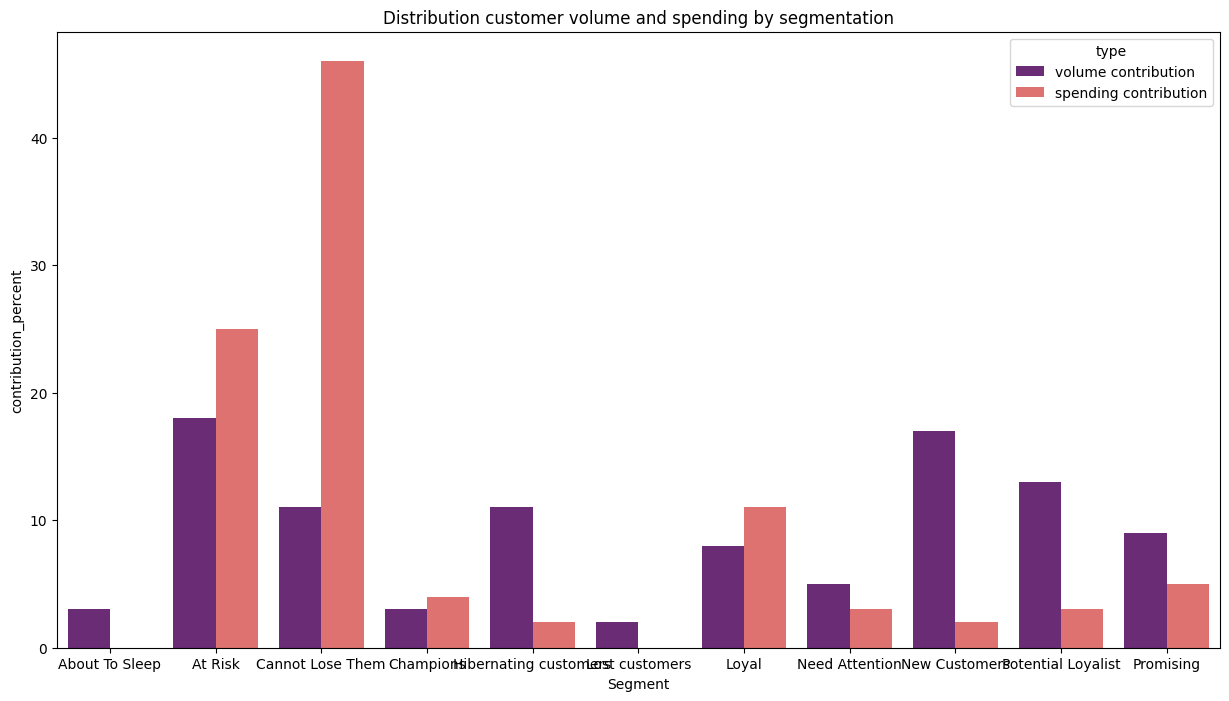

In [ ]:
# @title Distribution customer volume and spending by segmentation
# Find customer volume and spending by segmentation

#Customer volume
customer_volume = RFM_df_final[['Segment','CustomerID']].groupby(['Segment']).count().reset_index()
customer_volume.columns = ['Segment','Customer Volume']
customer_volume['contribution_percent'] = round(customer_volume['Customer Volume'] / customer_volume['Customer Volume'].sum()*100)
customer_volume['type'] = 'volume contribution'
#Customer spending
customer_spending = RFM_df_final[['Segment','Monetary']].groupby(['Segment']).sum().reset_index()
customer_spending.columns = ['Segment','Customer Spending']
customer_spending['contribution_percent'] = round(customer_spending['Customer Spending'] / customer_spending['Customer Spending'].sum()*100)
customer_spending['type'] = 'spending contribution'

#Merge
segment_agg = pd.concat([customer_volume,customer_spending])

plt.figure(figsize=(15,8))
sns.barplot(segment_agg, x='Segment', y='contribution_percent', hue='type', palette = 'magma')
plt.title('Distribution customer volume and spending by segmentation')
plt.show()


###Insights
- 'Cannot Lose Them' segment = Top spender with highest spending contribution (about 45 %) but volume contribution is much lower (about 11%) which means a small number of customers is generating huge revenue => Company should retain them with exclusive offers, early access, personal email.

- 'At Risk' segment = Big group, still valuable with high volume (about 18%) and high spending (about 25%). They used to spend a lot, but may be haven't come back recently => Company should realease 'win-back campaign' such as 'We miss you' emails, limited-time discount, personalized recommendations.

- 'New Customer' + 'Potential Loyalist' + 'Promising' = Majority of customer base with large volume group about 15% to 18% but low spending contribution about 5% to 8% => Company should consider to give them nuturing campain such as educational email flows, onboarding welcome discounts.

- 'Loyal' = Steady + Valuable with medium volume about 18% and good spending about 11% which are brand fans for company => They should receive Thank you letter from marketing campaign of company in the future.

- However, 'Champions' = Surprisingly small with very low in both volume and spending -> it can have issue about data gaps.

##5.2 Find potential customers to become loyal customers

In [ ]:
# @title Default title text
# Function to calculate percentile thresholds
def percentile_threshold(column):
  p_25 = column.quantile(0.25)
  p_50 = column.quantile(0.5)
  p_75 = column.quantile(0.75)
  quantile_list = [p_25,p_50,p_75]
  return quantile_list

# Function to assign quantile thresholds
def quantile_threshold(x, quantile_list):
  if x <= quantile_list[0]:
    value = f'q1: < {round(quantile_list[0])}' #Format as string with 2 decimal places
  elif x <= quantile_list[1]:
    value = f'q2: {round(quantile_list[0])} - {round(quantile_list[1])}'
  elif x <= quantile_list[2]:
    value = f'q3: {round(quantile_list[1])} - {round(quantile_list[2])}'
  else:
    value = f'q4: > {round(quantile_list[2])}'
  return value

# Apply threholds and assign bins for Quantity average
quantity_average_list = percentile_threshold(RFM_df_final['Avg_Quantity'])
RFM_df_final['Quantity_bin'] = RFM_df_final['Avg_Quantity'].apply(
    lambda x: quantile_threshold(x, quantity_average_list))

# Apply threholds and assign bins for Cost average
cost_average_list = percentile_threshold(RFM_df_final['Avg_Cost'])
RFM_df_final['Cost_bin'] = RFM_df_final['Avg_Cost'].apply(
    lambda x: quantile_threshold(x, cost_average_list))

#Apply threholds and assign bins for First quantity
first_quantity_list = percentile_threshold(RFM_df_final['First_Quantity'])
RFM_df_final['First_Quantity_bin'] = RFM_df_final['First_Quantity'].apply(
    lambda x: quantile_threshold(x, first_quantity_list))

#Apply threholds and assign bins for First cost
first_cost_list = percentile_threshold(RFM_df_final['First_Cost'])
RFM_df_final['First_Cost_bin'] = RFM_df_final['First_Cost'].apply(
    lambda x: quantile_threshold(x, first_cost_list))

#Update DataFrame
RFM_df_final.head()

,CustomerID,Recency,Frequency,Monetary,Start_Day,Start_Month,R,F,M,RFM,Segment,Loyal Status,Avg_Cost,Avg_Quantity,First_Cost,First_Quantity,Quantity_bin,Cost_bin,First_Quantity_bin,First_Cost_bin
0,12346.0,325,1,77183.60,2011-01-18,2011-01,5,1,5,515,Promising,None Loyal,77183.600000,74215.000000,77183.6,74215,q4: > 15,q4: > 25,q4: > 12,q4: > 26
1,12347.0,2,182,4310.00,2010-12-07,2010-12,1,5,5,155,Cannot Lose Them,None Loyal,23.681319,13.505495,25.2,12,q3: 10 - 15,q3: 18 - 25,q3: 8 - 12,q3: 16 - 26
2,12348.0,75,27,1595.64,2010-12-16,2010-12,4,2,4,424,Promising,None Loyal,59.097778,68.925926,39.6,72,q4: > 15,q4: > 25,q4: > 12,q4: > 26
3,12349.0,18,73,1757.55,2011-11-21,2011-11,2,4,4,244,At Risk,None Loyal,24.076027,8.643836,15.0,2,q2: 6 - 10,q3: 18 - 25,q1: < 3,q2: 10 - 16
4,12350.0,310,17,334.40,2011-02-02,2011-02,5,2,2,522,Promising,None Loyal,19.670588,11.588235,25.2,12,q3: 10 - 15,q3: 18 - 25,q3: 8 - 12,q3: 16 - 26


Text(0, 0.5, 'Customer Volume (%)')

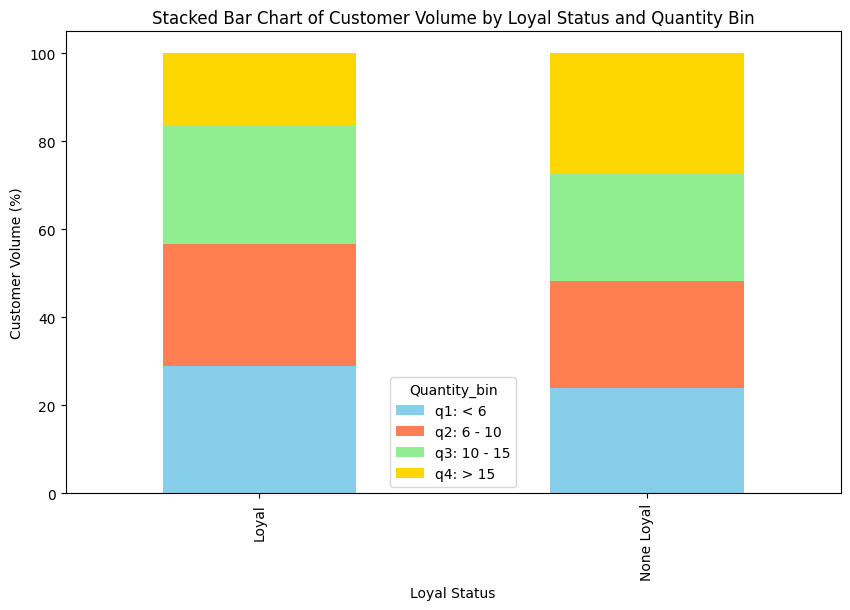

In [ ]:
# @title Stacked Bar Chart of Customer Volume by Loyal Status and Quantity Bin
#Calculate loyal_customer_volume and non_loyal_customer_volume
loyal_customer_volume = RFM_df_final[RFM_df_final['Loyal Status'] == 'Loyal']['CustomerID'].nunique()
non_loyal_customer_volume = RFM_df_final[RFM_df_final['Loyal Status'] == 'None Loyal']['CustomerID'].nunique()

#Group by Quantity_bin and count CustomerID
df = RFM_df_final[['CustomerID','Quantity_bin','Loyal Status']].groupby(['Quantity_bin','Loyal Status']).count().reset_index().rename(columns = {'CustomerID':'Customer Volume'})


#Calculate Customer_percent
df['Customer_percent'] = df.apply(
    lambda x: (x['Customer Volume'] / loyal_customer_volume) * 100 if x['Loyal Status'] == 'Loyal'
    else (x['Customer Volume'] / non_loyal_customer_volume) * 100, axis = 1
)

#Pivot Table to prepare for ploting
df_pivot = df.pivot(index = 'Loyal Status', columns = 'Quantity_bin', values = 'Customer_percent')

#Plot the 100% stacked bar chart
colors = ['skyblue', 'coral', 'lightgreen', 'gold']
df_pivot.plot(kind = 'bar', stacked = True, figsize=(10,6), title='Stacked Bar Chart of Customer Volume by Loyal Status and Quantity Bin', color = colors)
plt.xlabel('Loyal Status')
plt.ylabel('Customer Volume (%)')


### Insights
- Most of Loyal customers (left bar) fall into q3 and q4 (quantity > 10) -> makes sense because they've bought many times.
- However, Non Loyal cusotmers (right bar) still have a large portion in q3 and q4 (quantity > 10) which means although they've purchased quite a lot but still aren't tagged as Loyal customer => they are potential customers. Therefore, company should have specific marketing campaigns for them such as send them personalized offers, encourage them to make another purchase soon (to increase Recency) and recommend high-value products to increase Monetary score.

##5.3 Find indicator in R, F, and M should be most interested in

Overview about retail industry
In fact, retail business is often:
- High-trafic
- Low to medium price point per item
- Focus on repeat sales and volume
=> Recency (R) is most critical for retail because recent customers are more likely to return. Frequency (F) should be the second focus to identify loyal buyers and increase their purchasing behavior. While Monetary (M) is still important but it may not reflect loyalty on its own, especially in a retail setting where many customers make one-time large purchases.

<ipython-input-32-f39989f02e33>:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  recency_group = RFM_df_final.groupby('Recency_bin')['Monetary'].mean().reset_index()
<ipython-input-32-f39989f02e33>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=recency_group, x='Recency_bin', y='Monetary', palette='coolwarm')


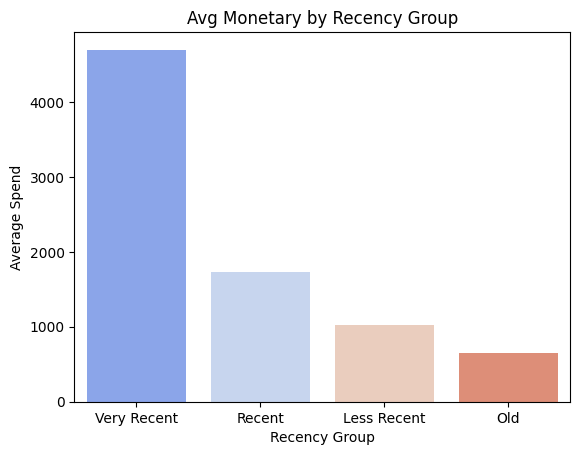

In [ ]:
#@title Average Monetary by Recency Group
# Create Recency bins
RFM_df_final['Recency_bin'] = pd.qcut(RFM_df_final['Recency'], 4, labels=['Very Recent', 'Recent', 'Less Recent', 'Old'])

# Compare average Monetary by Recency
recency_group = RFM_df_final.groupby('Recency_bin')['Monetary'].mean().reset_index()

sns.barplot(data=recency_group, x='Recency_bin', y='Monetary', palette='coolwarm')
plt.title("Avg Monetary by Recency Group")
plt.ylabel("Average Spend")
plt.xlabel("Recency Group")
plt.show()


###Insights
- 'Very Recent' customers spend the most who made a purchase most recently and are spending the highest average amount -> the more recently a customer buys, the more they tend to spend. Therefore, company should offer them loyalty offers, upsell, personalized discounts because they are most engaged and most valuable.
- There is sharp spend drop from 'Very Recent' to 'Recent'-> customers cool off quickly if not engaged => company should create re-engagement flow for customers who haven't bought in 30 to 60 days.
- 'Old' customers spend the least who have not purchased in a long time and are not generating value => company should run a last chance win-back campaign, if no respone, should exclude them from regular campaign to save budget.

=> Recency is a powerful driver of revenue in retail business.